## Query to filter Mongo database

```json

db.judgemnts.aggregate( [
   {$count: "myCount"},
   {$match: { "file_id": /^T/i }}
])


db.judgemnts.aggregate( [
   {$match: { "file_id": /^T/i }}
])

db.judgemnts.count({ "file_id": /^T/i })

db.judgemnts.find({ "file_id": /^T/i })


db.judgemnts.aggregate( [
   {
        $group: {
            "file_id": /^T/i,
             count: { $sum: 1 }
        }
   }
])


db.judgemnts.aggregate( [
   {
        $group: {
           _id: "$file_id",
           judgemnts: { $push: "$date" }
        }
   }
])


db.judgemnts.aggregate( [

   {
         $match: { "file_id": /^T/i }
   },
   {
        $group: {
           _id: "$file_id",
           count: { $sum: 1 }
        }
   }
])

```

## Load data

In [1]:
import re
import nltk
import string
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import sentiment
from nltk import word_tokenize
from wordcloud import WordCloud
from pandas_profiling import ProfileReport
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
data = pd.read_csv("data.csv",  encoding='utf8', low_memory=False )
data.shape

(4410, 10)

In [3]:
data.head()

_id  ...                                         collective
0  corteconstitucional_T-017/12  ...  [{"text":"república","label":"MISC","qty":1},{...
1  corteconstitucional_T-016/12  ...                                                NaN
2  corteconstitucional_T-014/12  ...                                                NaN
3  corteconstitucional_T-015/12  ...                                                NaN
4  corteconstitucional_T-012/11  ...                                                NaN

[5 rows x 10 columns]

In [4]:
data.iloc[1]

_id                                       corteconstitucional_T-016/12
date                                          2012-01-20T00:00:00.000Z
sentence_id                                                   T-016/12
topic                Debido proceso.  Tutela contra providencia jud...
report_receipt_at                                           2012-05-18
text                 REPÚBLICA DE COLOMBIA\n\n\nSentencia\r\nT-016/...
judicature           [{"name":"MARÍA VICTORIA CALLE CORREA","rol":"...
participants         [{"name":"MARIA YOLANDA MONTOYA BENITEZ","role...
vocabulary           [{"text":"república","qty":3},{"text":"colombi...
collective                                                         NaN
Name: 1, dtype: object

In [5]:
data.head(1)

_id  ...                                         collective
0  corteconstitucional_T-017/12  ...  [{"text":"república","label":"MISC","qty":1},{...

[1 rows x 10 columns]

In [6]:
from datetime import  datetime

In [7]:
data["date"] = pd.to_datetime(data["date"].str.slice(stop=10), infer_datetime_format=True)
data["report_receipt_at"] = pd.to_datetime(data.report_receipt_at)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   _id                4410 non-null   object        
 1   date               4410 non-null   datetime64[ns]
 2   sentence_id        4410 non-null   object        
 3   topic              4359 non-null   object        
 4   report_receipt_at  4402 non-null   datetime64[ns]
 5   text               4410 non-null   object        
 6   judicature         4410 non-null   object        
 7   participants       4347 non-null   object        
 8   vocabulary         4410 non-null   object        
 9   collective         16 non-null     object        
dtypes: datetime64[ns](2), object(8)
memory usage: 344.7+ KB


In [9]:
data.describe(datetime_is_numeric=True)

date              report_receipt_at
count                           4410                           4402
mean   2014-10-30 05:11:50.204081920  2015-01-27 21:16:06.651518464
min              2009-02-01 00:00:00            1969-12-31 00:00:00
25%              2012-06-05 00:00:00            2012-10-02 00:00:00
50%              2015-01-15 00:00:00            2015-03-09 12:00:00
75%              2017-03-07 00:00:00            2017-05-16 00:00:00
max              2019-10-08 00:00:00            2020-03-15 00:00:00

In [10]:
data.describe(include=["datetime64"], datetime_is_numeric=True).to_latex()

'\\begin{tabular}{lll}\n\\toprule\n{} &                           date &              report\\_receipt\\_at \\\\\n\\midrule\ncount &                           4410 &                           4402 \\\\\nmean  &  2014-10-30 05:11:50.204081920 &  2015-01-27 21:16:06.651518464 \\\\\nmin   &            2009-02-01 00:00:00 &            1969-12-31 00:00:00 \\\\\n25\\%   &            2012-06-05 00:00:00 &            2012-10-02 00:00:00 \\\\\n50\\%   &            2015-01-15 00:00:00 &            2015-03-09 12:00:00 \\\\\n75\\%   &            2017-03-07 00:00:00 &            2017-05-16 00:00:00 \\\\\nmax   &            2019-10-08 00:00:00 &            2020-03-15 00:00:00 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [11]:
import json
array_col = ["judicature", "participants", "collective", "vocabulary"]
for col in array_col:
  not_null_file = ~(data[col].isnull() | data[col].isna())
  data.loc[not_null_file, [col]] = data[not_null_file][col].apply(json.loads)

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


In [12]:
data["text"] = data["text"].str.lower()

In [13]:
new_data = pd.DataFrame([], columns = ['file_id', 'antecedentes' , 'decision'])

In [14]:
def quitar_tildes(cadena):
    s = ''.join((c for c in unicodedata.normalize('NFD',cadena) if unicodedata.category(c) != 'Mn'))
    return s

In [15]:
def get_segment(data):
    lista_df = []
    for index, row in data.iterrows():
        texto = re.split(
            r'[\n]+[(^i|^v|)]+\.\s{0,}[(\w)]{0,}?', 
            quitar_tildes(row["text"])
        )
        if len(texto) > 4:
            lista_df.append({"sentence_id": row["sentence_id"] , "antecedentes": texto[1], "decision": texto[4]})

    return lista_df

In [16]:
# data.text.apply(quitar_tildes).str.split(r'[\n]+[(^i|^v|)]+\.\s{0,}[(\w)]{0,}?', expand=True)

In [17]:
new_data = pd.DataFrame(get_segment(data), columns = ["sentence_id", 'antecedentes' , 'decision'])

In [18]:
new_data

sentence_id  ...                                           decision
0       T-014/12  ...  decision\n \ncon\r\nfundamento en las consider...
1       T-012/11  ...  decision\n \nen merito de lo expuesto, la\r\ns...
2       T-013/12  ...  decision\n \nen merito de lo expuesto, la sala...
3       T-012/12  ...  consideraciones de la corte constitucional\n \...
4       T-024/11  ...  decision \n \nen merito de lo expuesto, la sal...
...          ...  ...                                                ...
1857    T-239/19  ...  que no esten\r\nexpresamente incluidos en el p...
1858    T-205/19  ...  pruebas decretadas en sede de revision \n \nel...
1859    T-199/19  ...  existencia\r\nde un peligro especifico e indiv...
1860    T-192/19  ...  decision\n \nen merito de lo expuesto, la sala...
1861   SU.184/19  ...  sintesis\n \nen el presente caso, correspondio...

[1862 rows x 3 columns]

In [19]:
def quitar_espacios(text):
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\r', ' ', text)
    text = re.sub('\xa0', ' ', text)

    return text

new_data["decision"] = new_data.decision.apply(lambda x: quitar_espacios(x))
new_data["antecedentes"] = new_data.antecedentes.apply(lambda x: quitar_espacios(x))

In [20]:
def quita_signos(text):
    puntuacion = string.punctuation
    for item in puntuacion:
        text = text.replace(item, "")
    return text

new_data["decision"] = pd.DataFrame(new_data.decision.apply(lambda x: quita_signos(x)))
new_data["antecedentes"] = pd.DataFrame(new_data.antecedentes.apply(lambda x: quita_signos(x)))


In [21]:
new_data[200:300]

sentence_id  ...                                           decision
200    T-660/12  ...  consideraciones y fundamentos    competencia  ...
201    T-659/12  ...   se aprecia que la jurisprudencia ha sido radi...
202    T-615/11  ...  consideraciones y fundamentos   1 competencia ...
203    T-614/11  ...   decision   en merito de lo expuesto la sala s...
204    T-613/11  ...  antecedentes   1 en la sentencia t613 de 2011 ...
..          ...  ...                                                ...
295    T-496/11  ...  consideraciones y fundamentos   1 competencia ...
296    T-495/11  ...    paragrafo 3o se considera justa causa para d...
297    T-492/11  ...   decision   en merito de  lo expuesto la sala ...
298   A. 155/12  ...  decision   con fundamento  en las consideracio...
299   A. 128/11  ...  decision    en merito de  lo expuesto la corte...

[100 rows x 3 columns]

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
vectorizado = CountVectorizer(stop_words=stopwords.words("spanish"))
data_vectorizado= vectorizado.fit_transform(new_data.decision)
data_result = pd.DataFrame(data_vectorizado.toarray(), columns=vectorizado.get_feature_names())
data_result.index = new_data.index

In [24]:
data_result.head()

00  000  000000  00000210  ...  zunilda  zurita  zvtn  ºsentencia
0   0    0       0         0  ...        0       0     0           0
1   0    0       0         0  ...        0       0     0           0
2   0    0       0         0  ...        0       0     0           0
3   0    0       0         0  ...        0       0     0           0
4   0    0       0         0  ...        0       0     0           0

[5 rows x 83440 columns]

In [25]:
data_result = data_result.transpose()
data_result.head()

0     1     2     3     4     ...  1857  1858  1859  1860  1861
00           0     0     0     0     0  ...     0     0     0     0     0
000          0     0     0     0     0  ...     0     0     0     0     0
000000       0     0     0     0     0  ...     0     0     0     0     0
00000210     0     0     0     0     0  ...     0     0     0     0     0
00000422     0     0     0     0     0  ...     0     0     0     0     0

[5 rows x 1862 columns]

In [26]:
data

_id  ...                                         collective
0       corteconstitucional_T-017/12  ...  [{'text': 'república', 'label': 'MISC', 'qty':...
1       corteconstitucional_T-016/12  ...                                                NaN
2       corteconstitucional_T-014/12  ...                                                NaN
3       corteconstitucional_T-015/12  ...                                                NaN
4       corteconstitucional_T-012/11  ...                                                NaN
...                              ...  ...                                                ...
4405   corteconstitucional_A. 177/19  ...                                                NaN
4406  corteconstitucional_A. 177A/19  ...                                                NaN
4407   corteconstitucional_SU.139/19  ...                                                NaN
4408  corteconstitucional_A. 175A/19  ...                                                NaN
4409   corteconstitucional_A. 121/19  ...                                                NaN

[4410 rows x 10 columns]

## Top of words by Tutela

In [27]:
top_dict = {}
for item in data_result.columns:
    top = data_result[item].sort_values(ascending=False).head(30)
    top_dict[item]= list(zip(top.index, top.values))
print(top_dict)

{0: [('derechos', 8), ('tutela', 8), ('fundamentales', 7), ('accion', 7), ('sentencia', 7), ('articulo', 6), ('rodriguez', 5), ('venegas', 5), ('constitucional', 5), ('irremediable', 4), ('medios', 4), ('derecho', 4), ('hector', 4), ('fabio', 4), ('defensa', 4), ('constitucion', 4), ('perjuicio', 4), ('senor', 4), ('dictamen', 3), ('mismo', 3), ('amparo', 3), ('corte', 3), ('sala', 3), ('asi', 3), ('judiciales', 3), ('proteccion', 3), ('manera', 3), ('magistrado', 3), ('judicial', 3), ('procedera', 3)], 1: [('salud', 17), ('mp', 13), ('cuaderno', 12), ('expediente', 10), ('corte', 10), ('sentencia', 10), ('maria', 10), ('constitucional', 9), ('t2719663', 8), ('carmen', 8), ('zabala', 8), ('senora', 8), ('tutelante', 8), ('folio', 7), ('lopez', 7), ('servicios', 6), ('revision', 6), ('2010', 6), ('tutela', 6), ('primera', 6), ('riesgo', 5), ('derecho', 5), ('caso', 5), ('folios', 5), ('19', 5), ('accion', 5), ('convida', 5), ('epss', 5), ('tratamiento', 5), ('medico', 5)], 2: [('articul

## Most Popular words by Tutela

In [28]:
def nube_de_palabras(columna):
    wc = WordCloud(
        stopwords=stopwords.words("spanish"), 
        background_color="white", 
        colormap="Dark2",
        max_font_size=180, 
        random_state=42
    )


    plt.rcParams['figure.figsize'] = [16,12]
    count_graph = 0
    for index, row in new_data.iterrows():
        count_graph = index+1
        wc.generate(new_data[columna][index])
        plt.subplot(8, 8, count_graph)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title('File_ID')
        if count_graph == 64:
            break
    plt.show()

In [29]:
nube_de_palabras('decision')

In [35]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [65]:
stop_words = set(stopwords.words("spanish"))
word_list = [w for w in word_tokenize(" ".join(new_data['decision'])) if (not w in stop_words and not w.isnumeric() and len(w)>2)]

In [66]:
counts = Counter(word_list)

In [67]:
labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]
indexes = np.arange(len(labels))

In [68]:
limit=100
plt.bar(indexes[:limit], values[:limit])
plt.xticks(indexes[:limit], labels[:limit])
plt.xticks(rotation=90)
plt.show()

In [30]:
def nube_de_palabras2(columna):
    wc = WordCloud(
        stopwords=stopwords.words("spanish"), 
        background_color="white", 
        colormap="Dark2",
        max_font_size=180, 
        random_state=42
    )


    plt.rcParams['figure.figsize'] = [16,12]
    wc.generate(" ".join(new_data[columna]))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title('File_ID')

    plt.show()

nube_de_palabras2('decision')

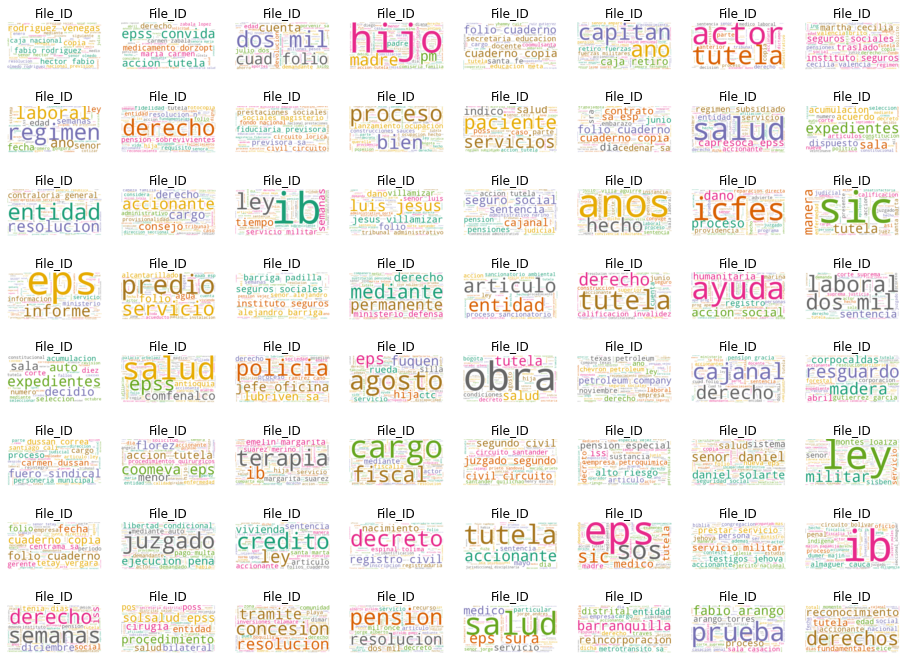

In [31]:
nube_de_palabras('antecedentes')

In [138]:
nube_de_palabras2('antecedentes')

In [69]:
stop_words = set(stopwords.words("spanish"))
word_list = [w for w in word_tokenize(" ".join(new_data['antecedentes'])) if (not w in stop_words and not w.isnumeric() and len(w)>2)]

In [70]:
counts = Counter(word_list)

In [71]:
labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]
indexes = np.arange(len(labels))

In [72]:
limit=100
plt.bar(indexes[:limit], values[:limit])
plt.xticks(indexes[:limit], labels[:limit])
plt.xticks(rotation=90)
plt.show()

In [73]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [74]:
analizador = SentimentIntensityAnalyzer()
analizador.polarity_scores("hiooasdmasasd sdfsdfsd")

{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

## polarity scores by Tutela

In [75]:
def sentimientos(new_data, columna):
    sentimientos_list = []
    for index, row in new_data.iterrows():
        scores = analizador.polarity_scores(row[columna])
        sentimientos_list.append({
            f"{columna}_negative": scores['neg'], 
            f"{columna}_neutral": scores['neu'], 
            f'{columna}_positivo': scores['pos'], 
        })
    return pd.DataFrame(sentimientos_list)


In [76]:
new_data.head()

sentence_id  ...                                           decision
0    T-014/12  ...  decision   con  fundamento en las consideracio...
1    T-012/11  ...  decision   en merito de lo expuesto la  sala p...
2    T-013/12  ...  decision   en merito de lo expuesto la sala te...
3    T-012/12  ...  consideraciones de la corte constitucional   1...
4    T-024/11  ...  decision    en merito de lo expuesto la sala n...

[5 rows x 3 columns]

In [ ]:
df_decision_sentimientos = sentimientos(new_data, 'decision')

In [ ]:
df_antecedentes_sentimientos = sentimientos(new_data, 'antecedentes')

In [ ]:
df_result_sentimientos = pd.concat([new_data, df_decision_sentimientos, df_antecedentes_sentimientos], axis=1, join="inner")

In [ ]:
df_result_sentimientos.shape

(1862, 9)

## New Dataframe with additional variables

In [ ]:
df_result_sentimientos.head()

file_id                                       antecedentes  \
0            T-3187308  antecedentes   1 hechos   1 el 27 de julio de ...   
1            T-2719663  antecedentes   1    hechos   el defensor del p...   
2            T-3176539  antecedentes   el ocho 8 de junio de dos mil  ...   
3            T-3180007  antecedentes   el senor juan antonio a traves ...   
4  T-2764991 Y 2822307  antecedentes   1 hechos   los hechos relatados...   

                                            decision  decision_negative  \
0  decision   con  fundamento en las consideracio...              0.019   
1  decision   en merito de lo expuesto la  sala p...              0.015   
2  decision   en merito de lo expuesto la sala te...              0.027   
3  consideraciones de la corte constitucional   1...              0.025   
4  decision    en merito de lo expuesto la sala n...              0.027   

   decision_neutral  decision_positivo  antecedentes_negative  \
0             0.977              0.004                  0.009   
1             0.981              0.004                  0.029   
2             0.968              0.005                  0.028   
3             0.955              0.020                  0.023   
4             0.959              0.014                  0.018   

   antecedentes_neutral  antecedentes_positivo  
0                 0.979                  0.012  
1                 0.964                  0.007  
2                 0.952                  0.020  
3                 0.965                  0.012  
4                 0.976                  0.006

In [ ]:
new_data.head()

file_id                                       antecedentes  \
0            T-3187308  antecedentes   1 hechos   1 el 27 de julio de ...   
1            T-2719663  antecedentes   1    hechos   el defensor del p...   
2            T-3176539  antecedentes   el ocho 8 de junio de dos mil  ...   
3            T-3180007  antecedentes   el senor juan antonio a traves ...   
4  T-2764991 Y 2822307  antecedentes   1 hechos   los hechos relatados...   

                                            decision  
0  decision   con  fundamento en las consideracio...  
1  decision   en merito de lo expuesto la  sala p...  
2  decision   en merito de lo expuesto la sala te...  
3  consideraciones de la corte constitucional   1...  
4  decision    en merito de lo expuesto la sala n...

In [ ]:
plt.rcParams['figure.figsize'] = [20, 16]

for index, row in enumerate(df_result_sentimientos[1:900].index):
    x = df_result_sentimientos[1:1500].decision_negative.loc[row]
    y = df_result_sentimientos[1:1500].decision_positivo.loc[row]
    plt.scatter(x, y, color='blue')
    plt.text(x+.001, y+.001, df_result_sentimientos['file_id'][index], fontsize=10)
    plt.xlim(-0.051, 0.152) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel(' Negative <--------> Positive -->', fontsize=8)
plt.ylabel(' --------> decision -->', fontsize=8)

plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [20, 16]

for index, row in enumerate(df_result_sentimientos[1:900].index):
    x = df_result_sentimientos[1:1500].antecedentes_negative.loc[row]
    y = df_result_sentimientos[1:1500].antecedentes_positivo.loc[row]
    plt.scatter(x, y, color='blue')
    plt.text(x+.001, y+.001, df_result_sentimientos['file_id'][index], fontsize=10)
    plt.xlim(-0.051, 0.152) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel(' Negative <--------> Positive -->', fontsize=8)
plt.ylabel('--------> antecedentes -->', fontsize=8)

plt.show()

In [ ]:
##new_data.drop(['neg'], axis=1)

In [ ]:
ProfileReport(df_result_sentimientos, title="Tutelas Profiling Report")

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]